# Symmetries, Representations and Projectors for arbitrary NQS
**Author: Louis Sharma (College de France), September 2025**

In this tutorial, we will discuss how to use symmetries of quantum Hamiltonian to enhance the performance of a VMC calculation. More specifically, you will learn:

* How to symmetrize a {class}`~netket.vqs.MCState` with respect to lattice symmetries. 
* How to implement custom symmetries.

We will consider the Heisenberg antiferromagnet on a 2d $L \times L$ square lattice: 

$$
\hat H = J \sum_{⟨ij⟩} \hat{\vec S}_i \cdot \hat{\vec S}_j
$$

where $J>0$ is the antiferromagnetic exchange coupling, $⟨ij⟩$ refers to pairs of first neighbor sites on the lattice and $\vec{\hat S}_i = \frac 12 ( \hat \sigma_i^x, \hat \sigma_i^y, \hat \sigma_i^z)$ is the spin operator for site $i$.

Through this tutorial we will consider both translation simmetries, the full space group of simmetries and the spin-flip simmetry.


## Definining the lattice a and computational basis (Hilbert space)
First, we need to define a square lattice. This is done using the {class}`~netket.graph.Square` class. For this tutorial, we will pick $L=4$.

Then, we need to define the Hilbert space on which this model is defined. The relevant class here is {class}`~netket.hilbert.Spin`.

Finally, we will construct the Hamiltonian of this system.
`NetKet` has built in Hamiltonians.

In [1]:
import netket as nk
import numpy as np
import jax
seed = jax.random.PRNGKey(1234) # For reproducibility

In [2]:
#define the square lattice
square_lattice = nk.graph.Square(length=4, pbc=True) # 4x4 square lattice with periodic boundary conditions

# Hilbert space
hilbert = nk.hilbert.Spin(s=0.5, N=square_lattice.n_nodes) #16 spin 1/2 particles 

H = nk.operator.Heisenberg(hilbert=hilbert, graph=square_lattice, J = 1.0, sign_rule=False)

We can investigate the lattice by using the {meth}`~netket.graph.Lattice.draw` method.

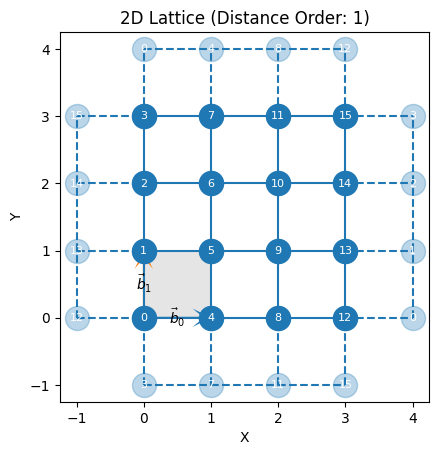

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [3]:
square_lattice.draw()

## Exact diagonalization

Since $\hat H$ is sparse and its dimension is not too big ( $ 2^{16}\approx 65k $ ), we can perform ED to get the ground state energy.

In [4]:
from scipy.sparse.linalg import eigsh

H_sp = H.to_sparse()
evals, evecs = eigsh(H_sp, k=1, which='SA')  # 'SA' means smallest algebraic eigenvalue
print("Ground state energy (exact diagonalization): ", evals[0])

Ground state energy (exact diagonalization):  -44.91393283371541


## Looking at the simmetries
The Hamiltonian commutes with the set of operators that correspond to a *representation* of the space group of the lattice. From representation theory, we know that we can use the irreducible representations (irreps) of the group to block diagonalize $\hat H$ and restrict the search for the ground state to a particular irrep. 


The first step in doing this is to select the relevant group. 

Here, we will consider the translation group of the lattice. 

In [5]:
translation_group = square_lattice.translation_group()
for g in translation_group: 
    print(g)

Id()
Translation([0, 1])
Translation([0, 2])
Translation([0, 3])
Translation([1, 0])
Translation([1, 1])
Translation([1, 2])
Translation([1, 3])
Translation([2, 0])
Translation([2, 1])
Translation([2, 2])
Translation([2, 3])
Translation([3, 0])
Translation([3, 1])
Translation([3, 2])
Translation([3, 3])


The elements of `translation_group` correspond to permutations of the lattice sites. 

In [6]:
print("Permutation corresponding to a translation by R= [0,1]: ", 
      translation_group[1].permutation_array)

Permutation corresponding to a translation by R= [0,1]:  [ 1  2  3  0  5  6  7  4  9 10 11  8 13 14 15 12]


We can also view the characters which classify different irreducible representations.

In [7]:
print("Second row of the character table:", translation_group.character_table()[1])

Second row of the character table: [ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  0.+1.j  0.+1.j  0.+1.j  0.+1.j -1.+0.j
 -1.+0.j -1.+0.j -1.+0.j  0.-1.j  0.-1.j  0.-1.j  0.-1.j]


As it turns out, the characters of the translation group can all be written in the form:

$$\chi_{\vec k}(\vec R) = e^{i \vec k \cdot \vec R}$$

where $\chi_{\vec k}(\vec R)$ is the character corresponding to the translation by a lattice vector $\vec R$ and $\vec k$ is a vector in the first Brillouin zone.  

In principle, the true ground state may be found at any value of $\vec k$. However, due to symmetry, we can restrict our search for the ground state to the *irreducible Brillouin zone* (red triangle on the plot below). 

Text(0.5, 1.0, 'Brillouin zone of the square lattice')

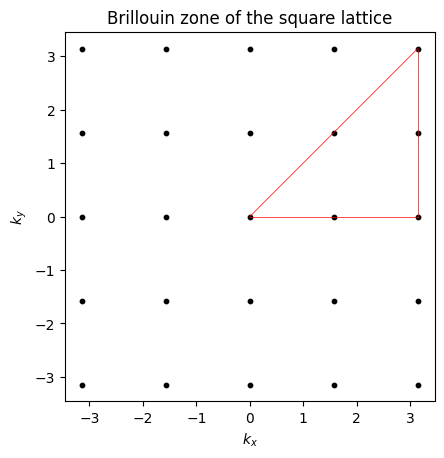

In [8]:
import matplotlib.pyplot as plt
kx = np.linspace(-np.pi, np.pi, 4+1, endpoint=True)
ky = np.linspace(-np.pi, np.pi, 4+1, endpoint=True)

Kx, Ky = np.meshgrid(kx, ky)
plt.scatter(Kx.flatten(), Ky.flatten(), s=10, color='black')
plt.plot([0,np.pi], [0, np.pi], color='r', lw=0.5)
plt.plot([0,np.pi], [0, 0], color='r', lw=0.5)
plt.plot([np.pi, np.pi], [0, np.pi], color='r', lw=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title('Brillouin zone of the square lattice')

The next step is to construct `netket.operator` objects from the group elements 
that can act on the states of the Hilbert space. This is known as a *representation*. For lattice symmetries, `NetKet` has built in methods
to construct representations using the {meth}`~netket.graph.Lattice.group_representation` method, which takes a Hilbert space and a permutation group as arguments.

In [ ]:
translation_group_representation = square_lattice.group_representation(
    hilbert=hilbert,
    group=square_lattice.translation_group()
)

In `NetKet`, a {class}`~netket.symmetry.Representation` object can be constructed by specifying a dictionary whose values are the elements of the representation. In this example, the elements of the translation group may be represented by {class}`~netket.operator.permutation.PermutationOperator` objects. These encode how permutations of the lattice sites act on the local degrees of freedom of the Hilbert space. 

For more details on the mathematical foundations of permutation operators, see the [symmetry documentation](../advanced/symmetry.md).


They are equipped with a `get_conn_padded` method, allowing them to act on states of the basis. 

In the next section, we will discuss in more detail how to construct {class}`~netket.symmetry.Representation` for custom groups.

## VMC

Within the VMC scheme, wavefunction amplitudes may be made symmetric with respect to a particular group $G$ and irrep $\mu$ using the following projection formula:

$$\psi_\mu(x) = \frac{d_\mu}{|G|} \sum_{g \in G} \chi_\mu^\ast(g) \psi( g^{-1}x)$$
where $x$ is the encoding of a basis state, $d_\mu$ is the dimension of the irrep, $|G|$ is the number of elements in the group, $\chi_\mu(g)$ is the character of the representation evaluated on element $g$ and $\hat U_g$ is the representation of $g$ on the Hilbert space. Here $\psi(g^{-1}x)$ is the *left action* of element $g$ on the state $x$. 

In the context of permutations and spin systems, we can view $g$ as a function from $\{0,\ldots, n-1\} \to \{0, \ldots, n-1\}$ and $x$ as a function from $\{0,\ldots, n-1\} \to \{0,1\}$ such that the left action is the composition:


$$\psi(g^{-1}x) = \psi(x \circ g)$$ 

For more mathematical details on permutations and their representations, see the [symmetry documentation](../advanced/symmetry.md).

In the following, we will compare the performance of an unsymmetrized ansatz versus a symmetrized one.

In [10]:
import jax.numpy as jnp
from netket.experimental.driver import VMC_SR

model = nk.models.RBM(param_dtype=np.complex128, alpha=2)
sampler = nk.sampler.MetropolisLocal(hilbert=hilbert) #Metropolis-Hastings local sampler
optimizer = nk.optimizer.Sgd(learning_rate=5e-3)
solver  = nk.optimizer.solver.cholesky #linear solver for the SR equations
diag_shift = 1e-6

In [16]:
#train the unsymmetrized model
unsymmetrized_log = nk.logging.RuntimeLog()
unsymmetrized_vstate = nk.vqs.MCState(sampler, 
                                      model, 
                                      n_samples = 512, 
                                      seed=seed)
driver = VMC_SR(
    hamiltonian=H, 
    optimizer=optimizer, 
    linear_solver=solver, 
    variational_state=unsymmetrized_vstate, 
    diag_shift=diag_shift,
    use_ntk=False
)
driver.run(n_iter=300, out=unsymmetrized_log);

  0%|                                                                                                         …

To construct a symmetry projected wavefunction in netket, we use `project` method of the {class}`~netket.symmetry.Representation` class. 
This method takes in a variational state as well as the integer correspond to the id of the irrep. It converts a state $\psi$ to the symmetrized one $\psi_\mu$ by implementing the projection described above.

In [17]:
# Create a new variational state to symmetrize it, using same seed
vstate=nk.vqs.MCState(sampler, model, n_samples = 512, seed=seed)
# Project on the trivial represention
translation_symmetric_vstate = translation_group_representation.project(
    state=vstate, 
    character_index=0
)

Then we just run the optimization as usual!

In [19]:
driver = VMC_SR(
    hamiltonian=H,
    optimizer=optimizer, 
    linear_solver=solver, 
    variational_state=translation_symmetric_vstate, 
    diag_shift=diag_shift,
    use_ntk=False,
)

# Takes a bit of time to run. Roughly 16 times longer
driver.run(n_iter=300, out=nk.logging.RuntimeLog())

  0%|                                                                                                         …

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

**Important**
In general, the ground state is not necessarily in the trivial sector. In practice, all relevant sectors should be scanned to find which one is energetically favorable. 
In the case of the translation group, this means all the points in the irreducible Brillouin zone should be checked. 

We can now compare the performance of the two models. 

In [20]:
def relative_error(approx, exact):
    return np.abs((approx - exact) / exact)

E_no_symm = float(unsymmetrized_vstate.expect(H).mean.real)
E_symm = float(translation_symmetric_vstate.expect(H).mean.real)

err_no  = 100 * relative_error(E_no_symm, evals[0])
err_sym = 100 * relative_error(E_symm, evals[0])

print(f"Energy without symmetrization: {E_no_symm:.4f}")
print(f"  Relative error: {err_no:.4f} %")

print(f"Energy with symmetrization (trivial irrep): {E_symm:.4f}")
print(f"  Relative error: {err_sym:.4f} %")

Energy without symmetrization: -43.2368
  Relative error: 3.7341 %
Energy with symmetrization (trivial irrep): -44.8494
  Relative error: 0.1438 %


## Implementing custom symmetries
The Heisenberg Hamiltonian also commutes with the spin flip operator:

$$\hat \sigma^x = \bigotimes_i \hat \sigma_i^x$$

The set of operators $\hat I, \hat \sigma^x$ form a representation of the group $\mathbb Z_2$

In this part of the tutorial, we will see how to construct a representation of this group in `NetKet` on our spin Hilbert space.

The {class}`~netket.symmetry.Representation` class needs two fundamental things to function:

* A {class}`~netket.utils.group.FiniteGroup` object. This just the group. 
* A `dict` object mapping elements of the group to operators on the Hilbert space. 

The group $\mathbb Z_2$ is just a set with 2 elements  $\{e, g\}$ with one rule: $g^2= e$. A simple example of a group that follows this blueprint is the symmetric group $\mathcal S_2.$ This group can be implemented in `NetKet` using the {class}`~netket.utils.group.PermutationGroup` class.

In [21]:
from netket.utils.group import PermutationGroup, Permutation
from netket.symmetry import Representation

In [22]:
e = np.array([0,1])
g = np.array([1,0])
group = PermutationGroup(
    elems=[
        Permutation(permutation_array=e, name='Identity()'), 
        Permutation(permutation_array=g, name="SpinFlip()")
    ], degree = 2 # should match the n of elements in the permutations.
)

In  `NetKet`, {class}`~netket.utils.group.Permutation` objects can be instantiated either by passing the permutation itself or the inverse permutation. To avoid potential confusions, this needs to be explicit. 

From the `group` variable, which is a {class}`~netket.utils.group.PermutationGroup` object, we can extract the characters, etc...

In [23]:
group.character_table()

array([[ 1.,  1.],
       [ 1., -1.]])

Next, we need to define the operators $\hat I$ and $\hat \sigma^x$ which furnish the representation of our group on the spin Hilbert space

In [25]:
spin_flip = nk.operator.PauliStrings(hilbert, "X"*square_lattice.n_nodes)

identity = nk.operator.spin.identity(hilbert=hilbert) #identity operator

To check that this all works as expected, recall that the states of the computational basis of our spin $1/2$ system are encoded as `jax.Array` objects:

* `array[i]` refers to the spin on the $i$th site. 
* `array[i] = -1` for spin down or `+1`for spin up

Therefore, we can generate a random state of the basis and apply our spin flip operator to it using the `get_conn_padded` method. 
The resulting array should send all $-1$ to $1$ and $1$ to $-1$ in the original array. 

In [27]:
# Generate a random state of the basis
state = hilbert.random_state(key=seed, size=1)
new_state, matrix_element = spin_flip.get_conn_padded(state)

print("Original state: ", state)
print("State after spin flip: ", new_state)
print("Sum of element-wise entries:", new_state + state)

Original state:  [[ 1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1]]
State after spin flip:  [[[-1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1]]]
Sum of element-wise entries: [[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]]


Now we create our dictionnary and pass it to instantiate a {class}`~netket.symmetry.Representation` object. Note that the keys of the dictionnary must be identical to the elements of the `group` argument.

In [28]:
representation_dict = {group[0]: identity, group[1]: spin_flip}
spin_flip_representation = Representation(
    group=group, 
    representation_dict=representation_dict
)

Now we can optimize a new vstate which is symmetric with respect to this group.

In [29]:
# Reinitialize the variational state to symmetrize it
vstate=nk.vqs.MCState(sampler, model, n_samples = 512, seed=seed) 
# Project on the trivial represention
spin_flip_symmetric_vstate = spin_flip_representation.project(
    state=vstate, 
    character_index=0
)

driver = VMC_SR(
    hamiltonian=H, 
    optimizer=optimizer, 
    linear_solver=solver, 
    variational_state=spin_flip_symmetric_vstate, 
    diag_shift=diag_shift
)
driver.run(n_iter=300, out=nk.logging.RuntimeLog());

Automatic SR implementation choice:  NTK


  0%|                                                                                                         …

In [31]:
E_spin_flip = float(spin_flip_symmetric_vstate.expect(H).mean.real)
err_spin = 100 * relative_error(E_spin_flip, evals[0])

print(f"Energy with spin-flip symmetry (trivial irrep): {E_spin_flip:.4f}")
print(f"  Relative error: {err_spin:.4f} %")

Energy with spin-flip symmetry (trivial irrep): -44.7569
  Relative error: 0.3497 %


## Combining representations
When we have two commuting groups, $G_1$ and $G_2$ and two representations $\hat U$ and $\hat V$ on the same vector space $\mathcal{H}$, 
we can define the following *product* representation $\hat \Gamma$ from $G_1 \times G_2 \to \mathcal{H}$  such that $\hat \Gamma(g_1 g_2) = \hat U_{g_1} \hat V_{g_2}$
As it turns out, characters of the irreps of $\hat \Gamma$, satisfy $\chi_{\mu, \nu}(g_1 g_2) = \chi_\mu(g_1) \chi_\nu(g_2)$  where $\chi_\mu(g_1)$ (resp. $\chi_\nu(g_2)$) are the characters of the irreps of $\hat U$ (resp. $\hat V$) evaluated on element $g_1$ (resp. $g_2$). 

We can apply this to the translation group and the spin-flip group! 
Essentially, we can combine these two groups and classify the eigenstates by their momentum and their spin flip parity. 
To do this in `NetKet`, we first project the state onto an irrep of one group then do another projection onto the other group. 

In [32]:
vstate=nk.vqs.MCState(sampler, model, n_samples = 512, seed=seed)
# Projector on the trivial representation
projector_T = translation_group_representation.projector(character_index=0)
# Projector on the trivial representation
projector_S = spin_flip_representation.projector(character_index=0)

# Combine the two projectors
projector_ST = projector_S @ projector_T

In [33]:
from netket._src.vqs.transformed_vstate import apply_operator

# Apply the combined projector to the vstate
trans_and_spin_symmetric_vstate = apply_operator(projector_ST, vstate)
driver = VMC_SR(
    hamiltonian=H, 
    optimizer=optimizer, 
    linear_solver=solver, 
    variational_state=trans_and_spin_symmetric_vstate, 
    diag_shift=diag_shift
)
# 150 steps since it will take longer to run
driver.run(n_iter=150, out=nk.logging.RuntimeLog())

Automatic SR implementation choice:  NTK


  0%|                                                                                                         …

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [34]:
E_product = float(trans_and_spin_symmetric_vstate.expect(H).mean.real)

results = [
    ("without symmetrization", E_no_symm),
    ("with spin-flip symmetry (trivial irrep)", E_spin_flip),
    ("with translation symmetry (trivial irrep)", E_symm),
    ("with product symmetry (trivial irrep)", E_product),
]

for label, energy in results:
    err = 100 * relative_error(energy, evals[0])
    print(f"Energy {label:35s}: {energy:8.4f}   Relative error: {err:6.4f} %")

Energy without symmetrization             : -43.2368   Relative error: 3.7341 %
Energy with spin-flip symmetry (trivial irrep): -44.7569   Relative error: 0.3497 %
Energy with translation symmetry (trivial irrep): -44.8494   Relative error: 0.1438 %
Energy with product symmetry (trivial irrep): -44.6955   Relative error: 0.4862 %


## Extension to fermionic systems

The concepts we've discussed so far naturally extend to fermionic systems, but there are two subtleties to bear in mind:

* On top of "spatial" degrees of freedom, fermionic Hilbert spaces may have additional degrees of freedom, like spin. 
* Fermionic states are antisymmetric with respect to particle exchange. 

In `NetKet` fermionic Hilbert spaces are handled by the {class}`~netket.hilbert.SpinOrbitalFermions` class.
Let's define a  spin $1/2$ fermion Hilbert space on the square lattice.

In [ ]:
fermion_hilbert = nk.hilbert.SpinOrbitalFermions(
    n_orbitals=square_lattice.n_nodes, 
    s = 1/2, 
    n_fermions_per_spin=(8,8) # Half-filling, zero spin
)
print("Size of basis states: ", fermion_hilbert.size)

So we need 32 occupation numbers to specify a state on the 16 site lattice. 

This is because  {class}`~netket.hilbert.SpinOrbitalFermions`' factorization is such that the first `n_orbitals` entries correspond to the occupations of spin sector `0` and so on. 
Therefore, a permutation of physical sites must be extended to match `hilbert.size`. 

Let's do a quick example with the translation operator.

In [36]:
T1_perm = translation_group[1].permutation_array
T1_perm_extended = np.concatenate(
    [T1_perm, T1_perm + fermion_hilbert.n_orbitals]
) #extend the permutation to the second spin sector
print("Extended permutation corresponding to a translation by R= [0,1]: ", T1_perm_extended)

Extended permutation corresponding to a translation by R= [0,1]:  [ 1  2  3  0  5  6  7  4  9 10 11  8 13 14 15 12 17 18 19 16 21 22 23 20
 25 26 27 24 29 30 31 28]


As it turns out, the correct way to define the representation $\hat U$ of a permutation group $G$ on a fermionic Hilbert space is by the following: for all $g\in G$ and basis states $|n\rangle$,

$$\hat U_g |n\rangle  = \xi_g(n) |n \circ g^{-1} \rangle $$

where $\xi_g(n)$ is the sign resulting from applying the permutation to the state $|n\rangle$. This sign is ultimately a consequence of the anti-commutation relations obeyed by the fermionic operators. More details can be found in the [symmetry documentation](../advanced/symmetry.md).


The {class}`~netket.operator.permutation.PermutationOperatorFermion` class is a good tool to hand representations of permutation groups on fermionic spaces. This class works similarly to {class}`~netket.operator.permutation.PermutationOperator` but its  `get_conn_padded` method also computes the sign.

In [37]:
from netket.operator.permutation import PermutationOperatorFermion

T1_fermion_perm = Permutation(permutation_array=T1_perm_extended, name="T[0,1]")
T1_fermion_op = PermutationOperatorFermion(fermion_hilbert, T1_fermion_perm)

#apply the operator to a batch of basis 
states = fermion_hilbert.random_state(key=seed, size=5)
new_states, matrix_elements = T1_fermion_op.get_conn_padded(states)
print("Matrix elements: ", matrix_elements)

Matrix elements:  [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]]


As you can see, some of the matrix elements are $-1$. 


Fortunately, for lattice permutation symmetries, `NetKet` can automatically construct {class}`~netket.symmetry.Representation` objects on fermionic spaces, 
without needing to manually extend the permutations. 

This is done by passing a {class}`~netket.hilbert.SpinOrbitalFermions` Hilbert space into `lattice.group_representation(hilbert, group)` where `group` can be obtained from methods like `translation_group()`, `rotation_group()`, `point_group()` or `space_group()`.

In [ ]:
fermi_translation_group_rep = square_lattice.group_representation(
    hilbert=fermion_hilbert,
    group=square_lattice.translation_group()
)
T01 = fermi_translation_group_rep.operators[1]

states_2, matrix_elements_2 = T01.get_conn_padded(states)

if np.all(matrix_elements == matrix_elements_2):
    print("The matrix elements are the same!")

if np.all(new_states == states_2):
    print("The new states are the same!")